## Importing model

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
from model import get_resnet50

model_normal = get_resnet50(pretrained=False) 
model_aug = get_resnet50(pretrained=False) 

#we want just the architecture, not resnet50 trained on imagenet.

/Users/aryan/Desktop/Academics /Semester 4/AI Software tools and techniques/data_augmentation_cs203/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/aryan/Desktop/Academics /Semester 4/AI Software tools and techniques/data_augmentation_cs203/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

## Importing datasets

In [6]:
train_normal_images = np.load("train_dataset/train_images.npy")
train_normal_labels = np.load("train_dataset/train_labels.npy")

train_aug_images = np.load("augmented_train/train_images.npy")
train_aug_labels = np.load("augmented_train/train_labels.npy")

## Training

In [7]:
# Normalize images and convert to torch tensors
def preprocess_images(images):
    images = images / 255.0  # Normalize to [0,1]
    images = np.transpose(images, (0, 3, 1, 2))  # Convert to (N, C, H, W)
    return torch.tensor(images, dtype=torch.float32)

train_normal_images = preprocess_images(train_normal_images)
train_aug_images = preprocess_images(train_aug_images)

# Convert labels to tensors
train_normal_labels = torch.tensor(train_normal_labels, dtype=torch.long)
train_aug_labels = torch.tensor(train_aug_labels, dtype=torch.long)

# Create DataLoader
BATCH_SIZE = 32

train_normal_loader = DataLoader(TensorDataset(train_normal_images, train_normal_labels), batch_size=BATCH_SIZE, shuffle=True)
train_aug_loader = DataLoader(TensorDataset(train_aug_images, train_aug_labels), batch_size=BATCH_SIZE, shuffle=True)

In [8]:
# Train Function
def train_model(model, train_loader, num_epochs=20, lr=0.001):
    model.to(device)  # Move model to MPS
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accuracies = []

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            # Move images and labels to MPS and ensure float32 dtype
            images, labels = images.to(device, dtype=torch.float32), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    return train_losses, train_accuracies

## Inference and Evaluation

In [9]:
test_images = np.load("test_dataset/test_images.npy")
test_labels = np.load("test_dataset/test_labels.npy")

In [10]:
test_images = preprocess_images(test_images)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)
test_loader = DataLoader(TensorDataset(test_images, test_labels_tensor), batch_size=BATCH_SIZE, shuffle=False)

In [11]:

# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return accuracy, precision, recall, f1

In [12]:
# Train models
print("\nTraining model_normal on non-augmented data...")
train_losses_normal, train_accuracies_normal = train_model(model_normal, train_normal_loader, num_epochs=20)

print("\nTraining model_aug on augmented data...")
train_losses_aug, train_accuracies_aug = train_model(model_aug, train_aug_loader, num_epochs=20)


Training model_normal on non-augmented data...
Epoch [1/20], Loss: 3.6019, Accuracy: 0.3393
Epoch [2/20], Loss: 1.0883, Accuracy: 0.5268
Epoch [3/20], Loss: 0.9562, Accuracy: 0.4375
Epoch [4/20], Loss: 0.6689, Accuracy: 0.6786
Epoch [5/20], Loss: 0.5507, Accuracy: 0.7143
Epoch [6/20], Loss: 0.5050, Accuracy: 0.7768
Epoch [7/20], Loss: 0.5401, Accuracy: 0.7232
Epoch [8/20], Loss: 0.4599, Accuracy: 0.7857
Epoch [9/20], Loss: 0.3367, Accuracy: 0.8571
Epoch [10/20], Loss: 0.2382, Accuracy: 0.9018
Epoch [11/20], Loss: 0.2080, Accuracy: 0.9286
Epoch [12/20], Loss: 0.1897, Accuracy: 0.9375
Epoch [13/20], Loss: 0.2787, Accuracy: 0.9107
Epoch [14/20], Loss: 0.2446, Accuracy: 0.9107
Epoch [15/20], Loss: 0.1982, Accuracy: 0.9107
Epoch [16/20], Loss: 0.2514, Accuracy: 0.9196
Epoch [17/20], Loss: 0.0485, Accuracy: 0.9911
Epoch [18/20], Loss: 0.0764, Accuracy: 0.9821
Epoch [19/20], Loss: 0.0808, Accuracy: 0.9643
Epoch [20/20], Loss: 0.0243, Accuracy: 1.0000

Training model_aug on augmented data...


In [13]:
# Visualization Function
def plot_training_curves(train_losses, train_accuracies):
    plt.figure(figsize=(12, 5))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-', color='#2E86C1', label="Training Loss")
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Training Loss Curve", fontsize=14, fontweight="bold")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='s', linestyle='-', color='#28B463', label="Training Accuracy")
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title("Training Accuracy Curve", fontsize=14, fontweight="bold")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    plt.tight_layout()
    plt.show()

#### Normal training

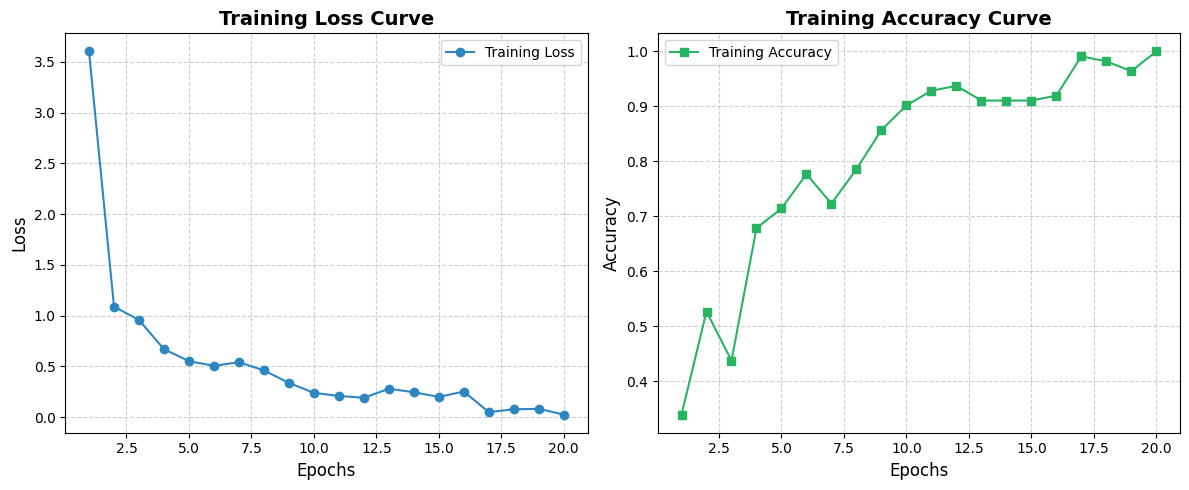

In [14]:
plot_training_curves(train_losses_normal, train_accuracies_normal)

#### Augmented trainset training

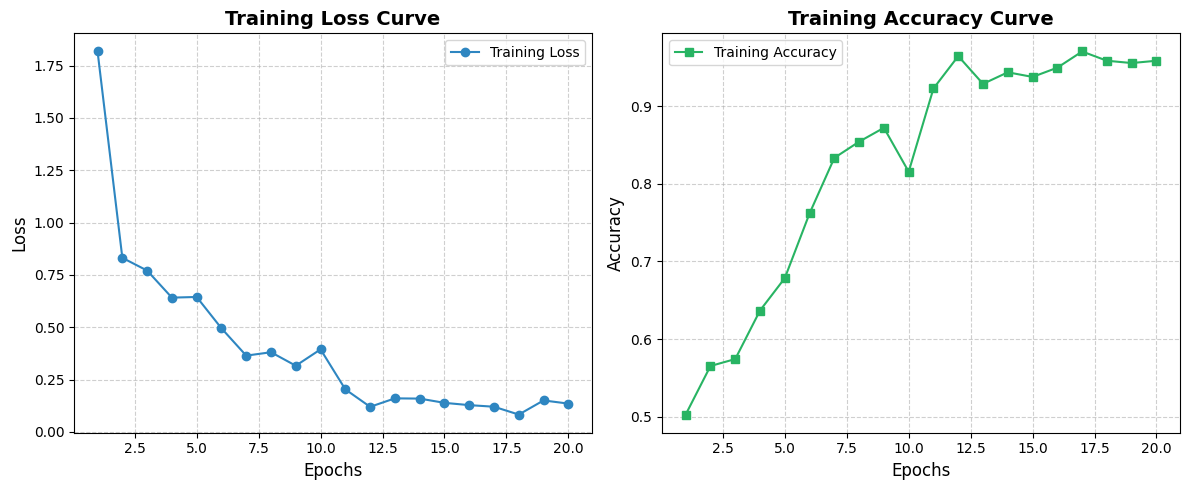

In [15]:
plot_training_curves(train_losses_aug, train_accuracies_aug)

## Scores 

In [18]:
# Evaluate models
acc_normal, prec_normal, rec_normal, f1_normal = evaluate_model(model_normal, test_loader)
acc_aug, prec_aug, rec_aug, f1_aug = evaluate_model(model_aug, test_loader)

print("\n ResNet50 (Normal Training) Results:")
print(f"   Accuracy:  {acc_normal:.4f}")
print(f"   Precision: {prec_normal:.4f}")
print(f"   Recall:    {rec_normal:.4f}")
print(f"   F1 Score:  {f1_normal:.4f}")

print("\n ResNet50 (Augmented Training) Results:")
print(f"   Accuracy:  {acc_aug:.4f}")
print(f"   Precision: {prec_aug:.4f}")
print(f"   Recall:    {rec_aug:.4f}")
print(f"   F1 Score:  {f1_aug:.4f}")


 ResNet50 (Normal Training) Results:
   Accuracy:  0.6786
   Precision: 0.6923
   Recall:    0.6429
   F1 Score:  0.6667

 ResNet50 (Augmented Training) Results:
   Accuracy:  0.6429
   Precision: 0.6429
   Recall:    0.6429
   F1 Score:  0.6429


## Training parameters

In [17]:
def get_training_info(model, optimizer, criterion):
    print("📝 Training Parameters:")
    print(f"- Model: {model.__class__.__name__}")
    print(f"- Optimizer: {optimizer.__class__.__name__}")
    for param_group in optimizer.param_groups:
        print(f"- Learning Rate: {param_group['lr']}")
    print(f"- Loss Function: {criterion.__class__.__name__}")

# Example usage:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_aug.parameters(), lr=0.001)

get_training_info(model_aug, optimizer, criterion)

📝 Training Parameters:
- Model: ResNet
- Optimizer: Adam
- Learning Rate: 0.001
- Loss Function: CrossEntropyLoss


## Interpretation 

### Traintime

We observe that during training, the accuracy for the augmented dataset does not rise as quickly as the normal dataset. This might seem counterintuitive, but it happens because augmentation adds variations, making the task harder initially. However, this increased diversity helps the model generalize better over time.

### Testtime

For normal training, the accuracy is 67.86%, meaning the model has learned something beyond random guessing (which would be 50% for binary classification). However, augmentation seems to slightly hurt accuracy, bringing it down to 64.29%. This suggests that while augmentation helps with generalization, it might have introduced some noise that made learning harder in this specific case.

Interestingly, all metrics (accuracy, precision, recall, F1-score) are identical for the augmented model, indicating a balanced behavior across classes. This could mean the model has become more conservative in its predictions, rather than being overly confident in one class.

### Extra

Recall drops (from 64.29% → 64.29%, meaning it remains the same), indicating that augmentation did not make the model more cautious about missing positive samples. <br>
F1 Score remains unchanged, meaning there’s no drastic shift in the trade-off between precision and recall. <br>
Precision slightly drops (from 69.23% → 64.29%), meaning the model has a bit more false positives. <br>

Overall, normal training performed slightly better, but augmentation may still be useful in different scenarios or with further tuning.